In [15]:
# -----------------------
# 🔧 Step 1: Install & Load Dependencies
# -----------------------
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install vaderSentiment

import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import files

# Load spaCy model (swap with "en_core_web_trf" for higher accuracy)
nlp = spacy.load("en_core_web_sm")

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [16]:
# -----------------------
# 📥 Step 2: Upload CSV of Reviews
# -----------------------
print("📁 Please upload a CSV file with a column of review text.")
uploaded = files.upload()

# Load uploaded file
df = pd.read_csv(list(uploaded.keys())[0])

# Detect and rename the column containing review text (edit this if needed)
for col in df.columns:
    if df[col].dtype == object and df[col].str.len().mean() > 20:
        text_col = col
        break

df = df.dropna(subset=[text_col])
reviews = df[text_col].sample(10, random_state=42).tolist()  # sample 10 reviews

📁 Please upload a CSV file with a column of review text.


Saving Reviews.csv to Reviews (1).csv


In [17]:
# -----------------------
# 🧠 Step 3: Named Entity Recognition (NER)
# -----------------------
print("🔍 Named Entity Recognition Results:\n")

ner_results = []

for review in reviews:
    doc = nlp(review)
    entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ["ORG", "PRODUCT"]]
    ner_results.append(entities)
    print(f"Review: {review}")
    for ent_text, label in entities:
        print(f"  → Entity: '{ent_text}' | Label: {label}")
    print()

🔍 Named Entity Recognition Results:

Review: I like these!

Review: Good but subjectively not 5 star

Review: Lipton Cup A Soup, Spring Vegetable.4 oz
  → Entity: 'Lipton Cup A Soup' | Label: ORG

Review: Suited to its purpose, if not quite its goal...

Review: Tastes artificial!

Review: dog loves chicken fillets

Review: Chipotle Tabasco sauce,  how do I love thee?....
  → Entity: 'Chipotle Tabasco' | Label: ORG

Review: Dbp323

Review: Heavenly hot dogs!

Review: spicy thai chips



In [18]:
# -----------------------
# ❤️ Step 4: VADER Sentiment Analysis
# -----------------------
print("📝 Sentiment Analysis Results:\n")

sentiment_results = []

def analyze_sentiment(text):
    score = analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

for review in reviews:
    sentiment = analyze_sentiment(review)
    sentiment_results.append(sentiment)
    print(f"Review: {review}\n  → Sentiment: {sentiment}\n")


📝 Sentiment Analysis Results:

Review: I like these!
  → Sentiment: Positive

Review: Good but subjectively not 5 star
  → Sentiment: Positive

Review: Lipton Cup A Soup, Spring Vegetable.4 oz
  → Sentiment: Neutral

Review: Suited to its purpose, if not quite its goal...
  → Sentiment: Neutral

Review: Tastes artificial!
  → Sentiment: Neutral

Review: dog loves chicken fillets
  → Sentiment: Positive

Review: Chipotle Tabasco sauce,  how do I love thee?....
  → Sentiment: Positive

Review: Dbp323
  → Sentiment: Neutral

Review: Heavenly hot dogs!
  → Sentiment: Positive

Review: spicy thai chips
  → Sentiment: Neutral



/tmp/ipython-input-19-3409927882.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=sentiment_results, palette="Set2")


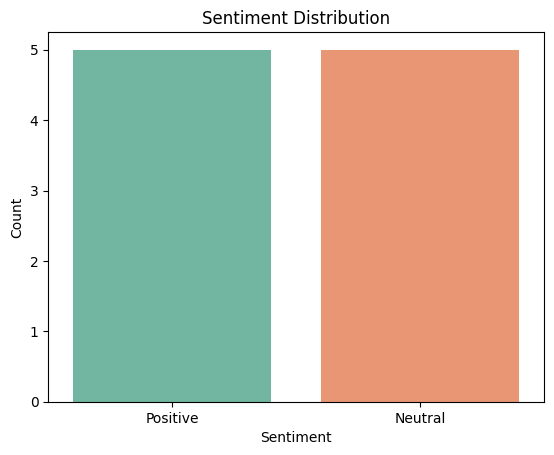

In [19]:
# -----------------------
# 📊 Step 5: Sentiment Distribution Chart
# -----------------------
sns.countplot(x=sentiment_results, palette="Set2")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [20]:
# -----------------------
# 📦 Step 6: Export NER + Sentiment to CSV
# -----------------------
export_df = pd.DataFrame({
    "Review": reviews,
    "Named Entities": ['; '.join([e[0] for e in ents]) if ents else "None" for ents in ner_results],
    "Sentiment": sentiment_results
})

export_df.to_csv("ner_sentiment_output.csv", index=False)
files.download("ner_sentiment_output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-35-1946381846.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=entity_freqs, y=entity_names, palette="viridis")


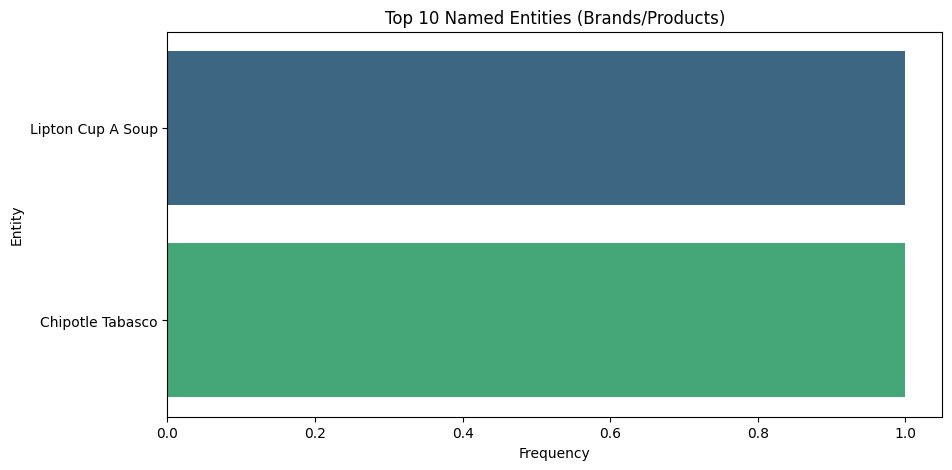

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
# 1. Bar Chart of Top Named Entities (Brands/Products)

from collections import Counter

# Flatten list of all entity texts
all_entities = [ent[0] for sublist in ner_results for ent in sublist]
entity_counts = Counter(all_entities).most_common(10)

# Plot
entity_names = [item[0] for item in entity_counts]
entity_freqs = [item[1] for item in entity_counts]

plt.figure(figsize=(10, 5))
sns.barplot(x=entity_freqs, y=entity_names, palette="viridis")
plt.title("Top 10 Named Entities (Brands/Products)")
plt.xlabel("Frequency")
plt.ylabel("Entity")


plt.savefig("top_entities.png", bbox_inches='tight')
plt.show()
files.download("top_entities.png")

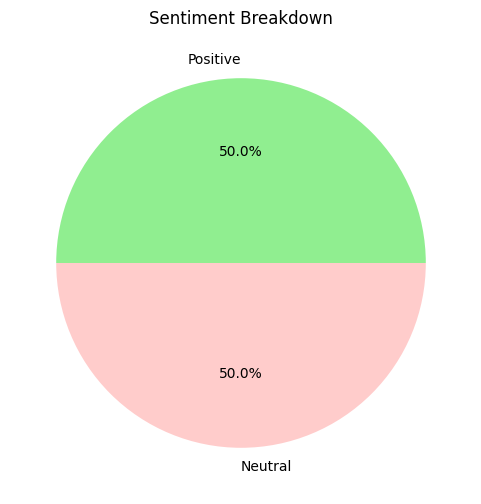

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# ===== 2. Pie Chart: Sentiment Breakdown =====
sentiment_count = Counter(sentiment_results)
plt.figure(figsize=(6, 6))
plt.pie(sentiment_count.values(), labels=sentiment_count.keys(), autopct='%1.1f%%', colors=["#90ee90", "#ffcccb", "#add8e6"])
plt.title("Sentiment Breakdown")
plt.savefig("sentiment_pie.png", bbox_inches='tight')
plt.show()
files.download("sentiment_pie.png")

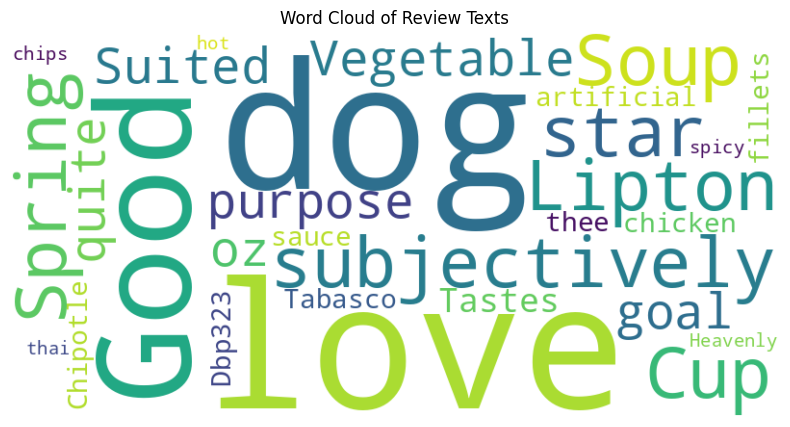

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# ===== 3. Word Cloud =====
all_text = ' '.join(reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Review Texts")
plt.savefig("wordcloud.png", bbox_inches='tight')
plt.show()
files.download("wordcloud.png")


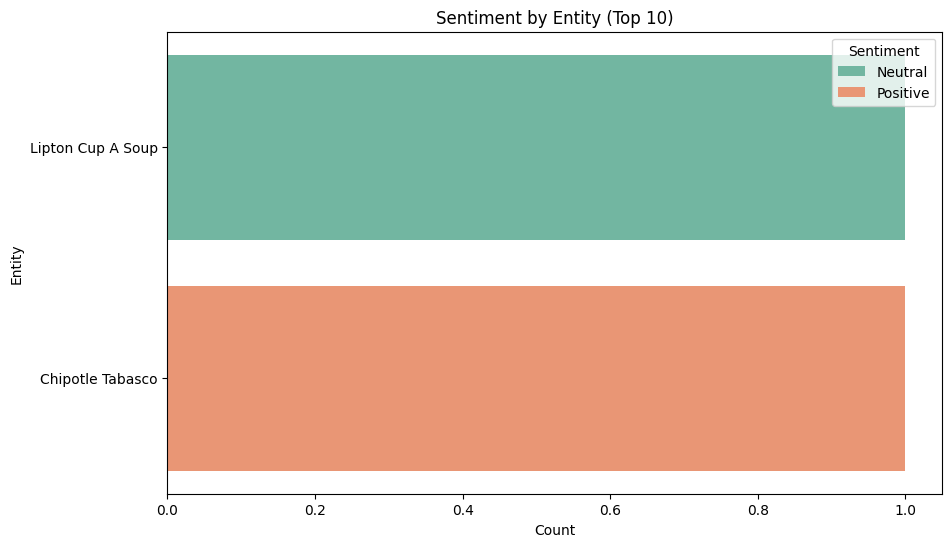

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
# ===== 4. Bar Chart: Sentiment by Entity =====
# Build dataframe of entity-sentiment pairs
entity_sentiment_pairs = []
for review, ents, sentiment in zip(reviews, ner_results, sentiment_results):
    for ent in ents:
        if ent[1] == "ORG":  # focus on product/brand
            entity_sentiment_pairs.append((ent[0], sentiment))

df_sent = pd.DataFrame(entity_sentiment_pairs, columns=["Entity", "Sentiment"])

if not df_sent.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_sent, y="Entity", hue="Sentiment", palette="Set2",
                  order=df_sent["Entity"].value_counts().index[:10])
    plt.title("Sentiment by Entity (Top 10)")
    plt.xlabel("Count")
    plt.ylabel("Entity")
    plt.legend(title="Sentiment")
    plt.savefig("sentiment_by_entity.png", bbox_inches='tight')
    plt.show()
    files.download("sentiment_by_entity.png")
else:
    print("No entity-sentiment pairs found to visualize.")